## Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection:
  1. Reorganize the dataset into a COCO format
  2. Reorganize the dataset into a middle format
  3. Implement a new dataset

We recommend the first two methods, as they are usually easier than the third.

In this tutorial, we give an example that converts the data into COCO format because MMDetection **only support evaluating mask AP of dataset in COCO format for now**. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/advanced_guides/customize_dataset.html).

First, let's download the [the balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon).

# Check the directory structure of the tiny data

# Install tree first in your terminal(linux)
sudo apt-get -q install tree


Checking the label corresponding to the instance split ID after the data format conversion is complete

In [4]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = '/mmdetection/grape/data/resize_blur10/train/annotation_coco.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Category ID: 1, Category Name: grape_berry


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [89]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

Given a config that trains a Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [90]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('grape_berry', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
# 使用する学習データのパスを指定
cfg.data_root = './data/resize_blur10'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/color'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/color/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val/annotation_coco.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = '../checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [7]:
!python ../tools/train.py {config}

06/05 11:16:09 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1085013561
    GPU 0,1,2,3,4,5,6,7: NVIDIA TITAN RTX
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.1, V11.1.105
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.9.0
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;a

In [2]:
%pip install "setuptools == 59.5.0" 

     |████████████████████████████████| 952 kB 13.1 MB/s eta 0:00:01     |█████████▎                      | 276 kB 13.1 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.2.0
    Uninstalling setuptools-60.2.0:
      Successfully uninstalled setuptools-60.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.0.10 requires setuptools~=60.2.0, but you have setuptools 59.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [16]:
%pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
     |████████████████████████████████| 6.0 MB 468 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 151 kB 10.4 MB/s eta 0:00:01
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
Note: you ma

In [11]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorboard'

In [7]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir tutorial_exps/

Reusing TensorBoard on port 6006 (pid 73392), started 13 days, 1:31:43 ago. (Use '!kill 73392' to kill it.)

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

### 1つの写真に対しての検出結果を表示

In [80]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame0.jpg',channel_order='rgb')
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth
<DetDataSample(

    META INFORMATION
    scale_factor: (1.6666666666666667, 1.6666666666666667)
    img_id: 0
    img_path: None
    img_shape: (800, 800)
    ori_shape: (480, 480)
    batch_input_shape: (800, 800)
    pad_shape: (800, 800)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], dtype=torch.int64)
            bboxes: tensor([], size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=480, width=480)
        ) at 0x7f8ec0af7850>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# 複数のフレームで重心点をトラッキング

## 重心点の抽出

In [15]:
import mmcv
from mmdet.apis import init_detector, inference_detector
results=[]
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
for i in range(5):
    img = mmcv.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame'+str(i)+'.jpg',channel_order='rgb')
    new_result = inference_detector(model, img)
    results.append(new_result)
# scoreが0.5以上のマスクを取り出す
high_score_indices = new_result.pred_instances['scores'] >= 0.6
high_score_masks = new_result.pred_instances['masks'][high_score_indices]

# 重心座標を保存するためのリスト
centroids = []

for mask in high_score_masks:
    true_indices = torch.nonzero(mask)
    if true_indices.size(0) > 0:  # Trueが含まれている場合のみ
        centroid = true_indices.float().mean(dim=0)
        centroids.append(centroid.tolist())  # 重心座標をリストに追加
# # CSVファイルに保存
# csv_file = "centroids.csv"
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Y", "X"])  # ヘッダーを書き込み
#     writer.writerows(centroids)  # 重心座標を書き込み

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


## 可視化

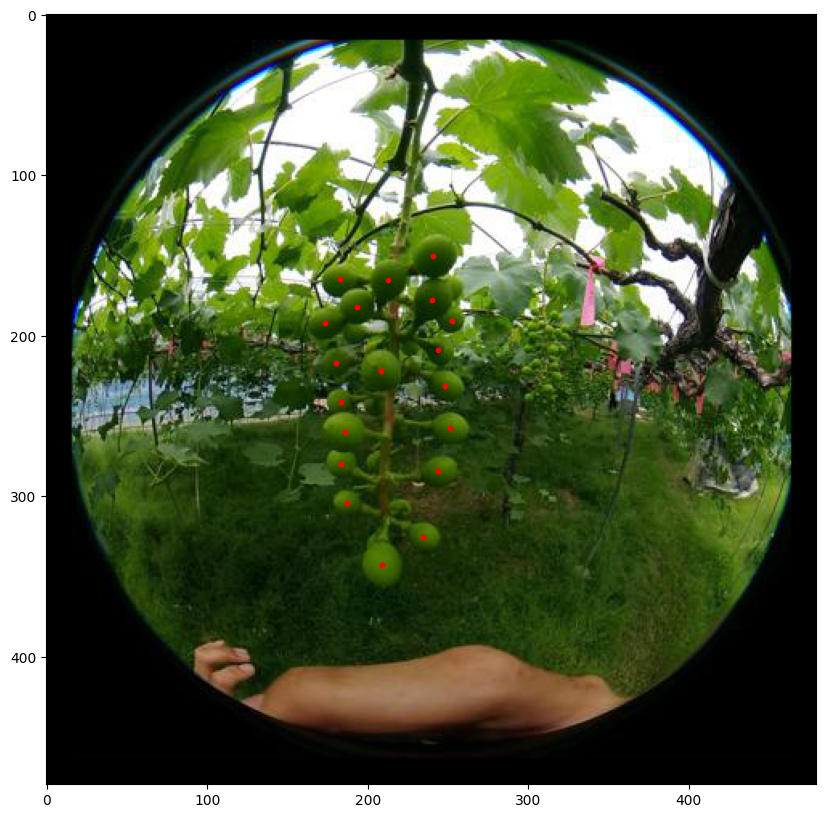

In [13]:
import matplotlib.pyplot as plt
image = plt.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame0.jpg')
plt.figure(figsize=(20,10))
plt.imshow(image)
for i in centroids:
    plt.scatter(i[1],i[0],s=10,c='red')
plt.savefig('center.pdf',format="pdf", dpi=300)

In [47]:
import torch
import csv
import matplotlib.pyplot as plt
from scipy.spatial import distance
import mmcv
from mmdet.apis import init_detector, inference_detector
results=[]
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
for i in range(5):
    img = mmcv.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame'+str(i)+'.jpg',channel_order='rgb')
    new_result = inference_detector(model, img)
    results.append(new_result)
# 重心座標を保存するためのリスト
all_centroids = []

for result in results:
    scores = result.pred_instances['scores']
    masks = result.pred_instances['masks']
    
    # scoreが0.5以上のマスクを取り出す
    high_score_indices = scores >= 0.6
    high_score_masks = masks[high_score_indices]
    
    centroids = []
    for mask in high_score_masks:
        true_indices = torch.nonzero(mask)
        if true_indices.size(0) > 0:  # Trueが含まれている場合のみ
            centroid = true_indices.float().mean(dim=0)
            centroids.append(centroid.tolist())  # 重心座標をリストに追加

    all_centroids.append(centroids)

# トラッキングの実装（最近傍法）
tracked_centroids = []

# 最初のフレームの重心座標を初期位置として使用
previous_centroids = all_centroids[0]
tracked_centroids.append(previous_centroids)
print(tracked_centroids)
for frame_idx in range(1,len(results)):
    current_centroids = all_centroids[frame_idx]
    new_tracked_centroids = []

    for prev_centroid in previous_centroids:
        if prev_centroid == [None, None]:
            new_tracked_centroids.append([None, None])
            continue

        # 最近傍の重心を見つける
        distances = [distance.euclidean(prev_centroid, cur_centroid) if cur_centroid != [None, None] else float('inf') for cur_centroid in current_centroids]
        nearest_centroid_idx = distances.index(min(distances))
        new_tracked_centroids.append(current_centroids[nearest_centroid_idx])

    tracked_centroids.append(new_tracked_centroids)
    previous_centroids = new_tracked_centroids



[[[222.17587280273438, 208.11892700195312], [150.28550720214844, 240.82752990722656], [181.70217895507812, 193.01739501953125], [165.14768981933594, 212.82028198242188], [257.3771667480469, 251.27047729492188], [284.48699951171875, 243.6430206298828], [342.7206726074219, 208.899169921875], [192.2108917236328, 173.4308319091797], [164.30091857910156, 182.8101806640625], [260.1169738769531, 185.5603790283203], [177.6266632080078, 240.07333374023438], [231.08311462402344, 248.30389404296875], [325.22222900390625, 234.7142791748047], [216.63636779785156, 180.01673889160156], [279.8699035644531, 183.05575561523438], [190.50704956054688, 252.76055908203125], [304.192626953125, 187.13934326171875], [241.0766143798828, 183.1774139404297], [209.0036163330078, 243.5036163330078]]]


## 可視化

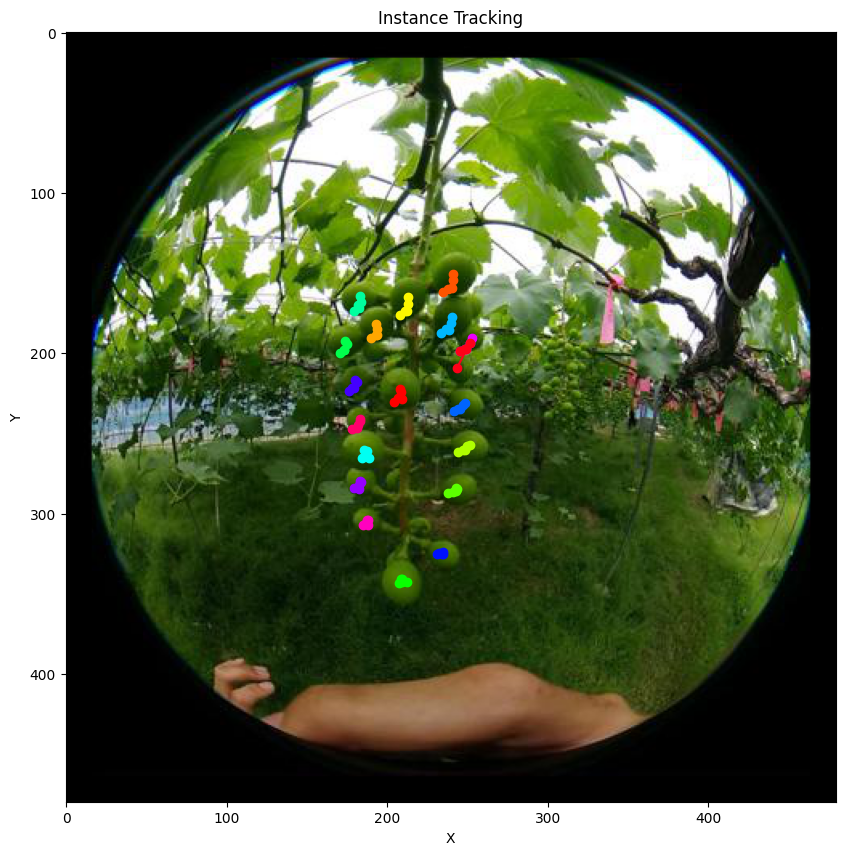

<Figure size 640x480 with 0 Axes>

In [43]:
# トラッキング結果を可視化
colors = plt.cm.get_cmap('hsv', len(tracked_centroids[0]))

plt.figure(figsize=(10, 10))
for instance_idx in range(len(tracked_centroids[0])):
    x_coords = [frame[instance_idx][1] for frame in tracked_centroids if frame[instance_idx] != [None, None]]
    y_coords = [frame[instance_idx][0] for frame in tracked_centroids if frame[instance_idx] != [None, None]]
    plt.plot(x_coords, y_coords, marker='o', color=colors(instance_idx))
image = plt.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame0.jpg')
plt.imshow(image)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Instance Tracking')
plt.show()
plt.savefig('track.pdf',format="pdf", dpi=300)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


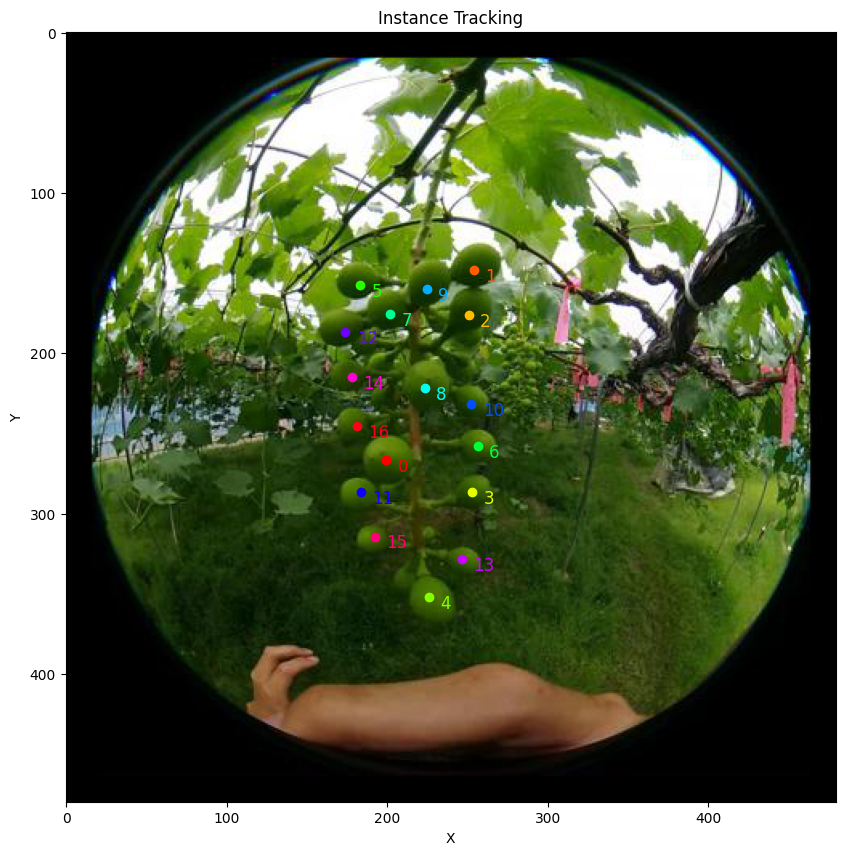

トラッキング結果を tracked_centroids2.csv に保存しました。


<Figure size 640x480 with 0 Axes>

In [86]:
import torch
import csv
import matplotlib.pyplot as plt
from scipy.spatial import distance
import mmcv
from mmdet.apis import init_detector, inference_detector
results=[]
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
for i in range(9,10):
    img = mmcv.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame'+str(i)+'.jpg',channel_order='rgb')
    new_result = inference_detector(model, img)
    results.append(new_result)
# 重心座標を保存するためのリスト
all_centroids = []

for result in results:
    scores = result.pred_instances['scores']
    masks = result.pred_instances['masks']
    
    # scoreが0.5以上のマスクを取り出す
    high_score_indices = scores >= 0.6
    high_score_masks = masks[high_score_indices]
    
    centroids = []
    for mask in high_score_masks:
        true_indices = torch.nonzero(mask)
        if true_indices.size(0) > 0:  # Trueが含まれている場合のみ
            centroid = true_indices.float().mean(dim=0)
            centroids.append(centroid.tolist())  # 重心座標をリストに追加

    all_centroids.append(centroids)

# トラッキングの実装（最近傍法）
tracked_centroids = []

# 初期のインデックス
current_index = len(all_centroids[0])
# 最初のフレームの重心座標を初期位置として使用
previous_centroids = all_centroids[0]
tracked_centroids.append([(centroid, idx) for idx, centroid in enumerate(previous_centroids)])
previous_centroids = [(centroid, idx) for idx, centroid in enumerate(previous_centroids)]
threshold_distance = 5.0
for frame_idx in range(1,len(results)):
    current_centroids = all_centroids[frame_idx]
    new_tracked_centroids = []
    
    for prev_centroid, prev_idx in previous_centroids:
        if prev_centroid == [None, None]:
            new_tracked_centroids.append(([None, None], prev_idx))
            continue

        # 最近傍の重心を見つける
        distances = [distance.euclidean(prev_centroid, cur_centroid) if cur_centroid != [None, None] else float('inf') for cur_centroid in current_centroids]
        if min(distances) <= threshold_distance:
            nearest_centroid_idx = distances.index(min(distances))
            new_tracked_centroids.append((current_centroids[nearest_centroid_idx], prev_idx))
        else:
            new_tracked_centroids.append(([None,None], prev_idx))
            
    tracked_centroids.append(new_tracked_centroids)
    previous_centroids = new_tracked_centroids
# トラッキング結果を可視化
colors = plt.cm.get_cmap('hsv', len(tracked_centroids[0]))

plt.figure(figsize=(10, 10))
for instance_idx in range(current_index):
    x_coords = [frame[instance_idx][0][1] for frame in tracked_centroids if frame[instance_idx][0] != [None, None]]
    y_coords = [frame[instance_idx][0][0] for frame in tracked_centroids if frame[instance_idx][0] != [None, None]]
    plt.plot(x_coords, y_coords, marker='o', color=colors(instance_idx))
    plt.text(x_coords[-1]+7, y_coords[-1]+7, str(instance_idx), fontsize=12, color=colors(instance_idx % current_index))
image = plt.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame10.jpg')
plt.imshow(image)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Instance Tracking')
plt.show()
plt.savefig('track.pdf',format="pdf", dpi=300)
# CSVファイルに保存
csv_file = "tracked_centroids2.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "Instance", "X", "Y"])  # ヘッダーを書き込み

    for frame_idx, centroids in enumerate(tracked_centroids):
        for centroid, instance_idx in centroids:
            if centroid != [None, None]:
                writer.writerow([frame_idx, instance_idx, centroid[1], centroid[0]])

print(f"トラッキング結果を {csv_file} に保存しました。")

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


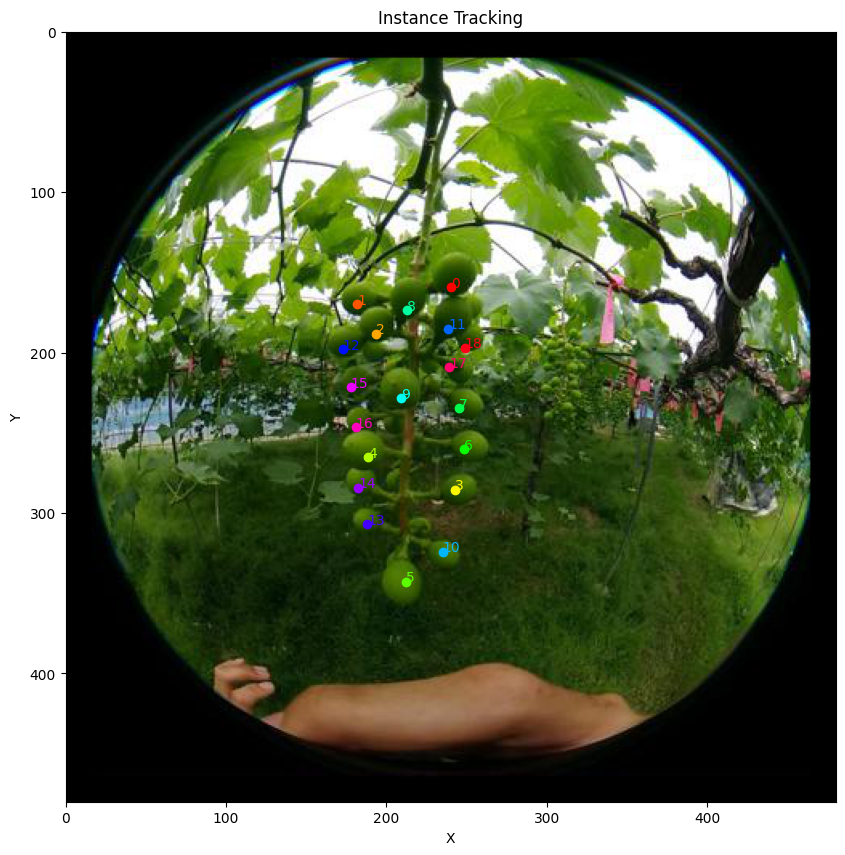

トラッキング結果を tracked_centroids5.csv に保存しました。


<Figure size 640x480 with 0 Axes>

In [108]:
import torch
import csv
import matplotlib.pyplot as plt
from scipy.spatial import distance
import mmcv
from mmdet.apis import init_detector, inference_detector

results=[]
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
for i in range(4,5):
    img = mmcv.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame' + str(i) + '.jpg', channel_order='rgb')
    new_result = inference_detector(model, img)
    results.append(new_result)

# 重心座標を保存するためのリスト
all_centroids = []

for result in results:
    scores = result.pred_instances['scores']
    masks = result.pred_instances['masks']
    
    # scoreが0.5以上のマスクを取り出す
    high_score_indices = scores >= 0.6
    high_score_masks = masks[high_score_indices]
    
    centroids = []
    for mask in high_score_masks:
        true_indices = torch.nonzero(mask)
        if true_indices.size(0) > 0:  # Trueが含まれている場合のみ
            centroid = true_indices.float().mean(dim=0)
            centroids.append(centroid.tolist())  # 重心座標をリストに追加

    all_centroids.append(centroids)

# トラッキングの実装（最近傍法）
tracked_centroids = []

# 初期のインデックス
current_index = len(all_centroids[0])
# 最初のフレームの重心座標を初期位置として使用
previous_centroids = all_centroids[0]
tracked_centroids.append([(centroid, idx) for idx, centroid in enumerate(previous_centroids)])
previous_centroids = [(centroid, idx) for idx, centroid in enumerate(previous_centroids)]
threshold_distance = 10.0

for frame_idx in range(1, len(results)):
    current_centroids = all_centroids[frame_idx]
    new_tracked_centroids = []

    for cur_centroid in current_centroids:
        # 最近傍の重心を見つける
        distances = [distance.euclidean(cur_centroid, prev_centroid[0]) if prev_centroid[0] != [None, None] else float('inf') for prev_centroid in previous_centroids]
        if min(distances) <= threshold_distance:
            nearest_centroid_idx = distances.index(min(distances))
            nearest_centroid = previous_centroids[nearest_centroid_idx]
            new_tracked_centroids.append((cur_centroid, nearest_centroid[1]))
        else:
            new_tracked_centroids.append((cur_centroid, current_index))
            current_index+=1
            
    # Previous centroidsを更新するために、対応しなかったprevious centroidsをNoneに設定
    for prev_centroid in previous_centroids:
        if prev_centroid not in [tracked_centroid for tracked_centroid, _ in new_tracked_centroids]:
            new_tracked_centroids.append(([None, None], prev_centroid[1]))

    tracked_centroids.append(new_tracked_centroids)
    previous_centroids = new_tracked_centroids

# トラッキング結果を可視化
colors = plt.cm.get_cmap('hsv', len(tracked_centroids[0]))

plt.figure(figsize=(10, 10))
for frame_idx, frame in enumerate(tracked_centroids):
    for centroid, track_id in frame:
        if centroid != [None, None]:
            plt.scatter(centroid[1], centroid[0], color=colors(track_id), label=f'Track {track_id}' if frame_idx == 0 else "")
            plt.text(centroid[1], centroid[0], f'{track_id}', color=colors(track_id))
image = plt.imread('/workspace/mmdetection-grape/grape/raw_data/R0010110/frame0.jpg')
plt.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Instance Tracking')
plt.show()
plt.savefig('track.pdf', format="pdf", dpi=300)

# CSVファイルに保存
csv_file = "tracked_centroids5.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "Instance", "X", "Y"])  # ヘッダーを書き込み

    for frame_idx, centroids in enumerate(tracked_centroids):
        for centroid, instance_idx in centroids:
            if centroid != [None, None]:
                writer.writerow([frame_idx, instance_idx, centroid[1], centroid[0]])

print(f"トラッキング結果を {csv_file} に保存しました。")


In [72]:
# CSVファイルに保存
csv_file = "tracked_centroids.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "Instance", "X", "Y"])  # ヘッダーを書き込み

    for frame_idx, centroids in enumerate(tracked_centroids):
        for instance_idx, centroid in enumerate(centroids):
            if centroid != [None, None]:
                writer.writerow([frame_idx, instance_idx, centroid[1], centroid[0]])

print(f"トラッキング結果を {csv_file} に保存しました。")


トラッキング結果を tracked_centroids.csv に保存しました。


In [60]:
from mmengine.visualization import Visualizer
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()

RuntimeError: Before calling Visualizer.get_current_instance(), you should call get_instance(name=xxx) at least once.

### フォルダ内の全ての写真に対しての検出結果を表示

In [8]:
import mmcv
from mmengine.visualization import Visualizer
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
import os

def show_result_pyplot(img_folder_path, output_folder_path):
    checkpoint_file = 'tutorial_exps/epoch_12.pth'
    model = init_detector(cfg, checkpoint_file, device='cpu')
    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta
    for img_path in os.listdir(img_folder_path):
        img = mmcv.imread(img_folder_path + img_path, channel_order='rgb')
        new_result = inference_detector(model, img)
        visualizer.add_datasample(
            'new_result',
            img,
            data_sample=new_result,
            draw_gt=False,
            wait_time=0,
            out_file=f'{output_folder_path}/{img_path}',
            pred_score_thr=0.5
        )

In [10]:
image_folder = '/workspace/mmdetection-grape/grape/raw_data/R0010110/'
output_folder = '/workspace/mmdetection-grape/grape/data/R0010110_output/'
show_result_pyplot(image_folder, output_folder)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


/opt/conda/lib/python3.7/site-packages/mmengine/utils/manager.py:114: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  f'{cls} instance named of {name} has been created, '


In [1]:
pwd

'/workspace/mmdetection-grape/grape'